# Домашнее задание по теме  
## «Кластеризация k-means» 

Импорт библиотек

In [1]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples

import matplotlib.cm as cm

import joblib

### Загрузка данных

In [2]:
# Загрузка данных
# Использую обработанные данные из задачи уменьшения размерности PSA
archive_path = 'input_data/processed_penguins.zip'
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('processed_penguins.csv') as file:
        df = pd.read_csv(file)

In [3]:
#  подготовка данных для кластеризации
X = df.drop(columns=['sex'])

In [4]:
# Стандартизация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)
X_scaled = scaler.fit_transform(X)

### Подбор гиперпараметров для кластеризации

- метод локтя

In [5]:
# Диапазоны для гиперпараметров
n_clusters_range = range(2, 11)  # Кол-во кластеров
init_methods = ['k-means++', 'random']  # Методы инициализации центроидов
max_iter_range = [100, 300]  # Максимальное количество итераций
algorithms = ['lloyd', 'elkan']  # Алгоритмы для K-means

# Создаем структуру для хранения результатов
results = []

# Перебор комбинаций гиперпараметров
for n_clusters in n_clusters_range:
    for init in init_methods:
        for max_iter in max_iter_range:
            for algorithm in algorithms:
                # Модель KMeans с текущими гиперпараметрами
                kmeans = KMeans(
                    n_clusters=n_clusters,
                    init=init,
                    max_iter=max_iter,
                    algorithm=algorithm,
                    random_state=42
                )
                kmeans.fit(X_scaled)  # Обучение
                inertia = kmeans.inertia_  # Инерция
                
                # Сохранение результатов
                results.append({
                    'n_clusters': n_clusters,
                    'init': init,
                    'max_iter': max_iter,
                    'algorithm': algorithm,
                    'inertia': inertia
                })

# Рзультаты в DataFrame
results_df = pd.DataFrame(results)

# Выводим результаты
print(results_df)

    n_clusters       init  max_iter algorithm     inertia
0            2  k-means++       100     lloyd  551.343376
1            2  k-means++       100     elkan  551.343376
2            2  k-means++       300     lloyd  551.343376
3            2  k-means++       300     elkan  551.343376
4            2     random       100     lloyd  551.343376
..         ...        ...       ...       ...         ...
67          10  k-means++       300     elkan  149.401900
68          10     random       100     lloyd  146.475082
69          10     random       100     elkan  146.475082
70          10     random       300     lloyd  146.475082
71          10     random       300     elkan  146.475082

[72 rows x 5 columns]


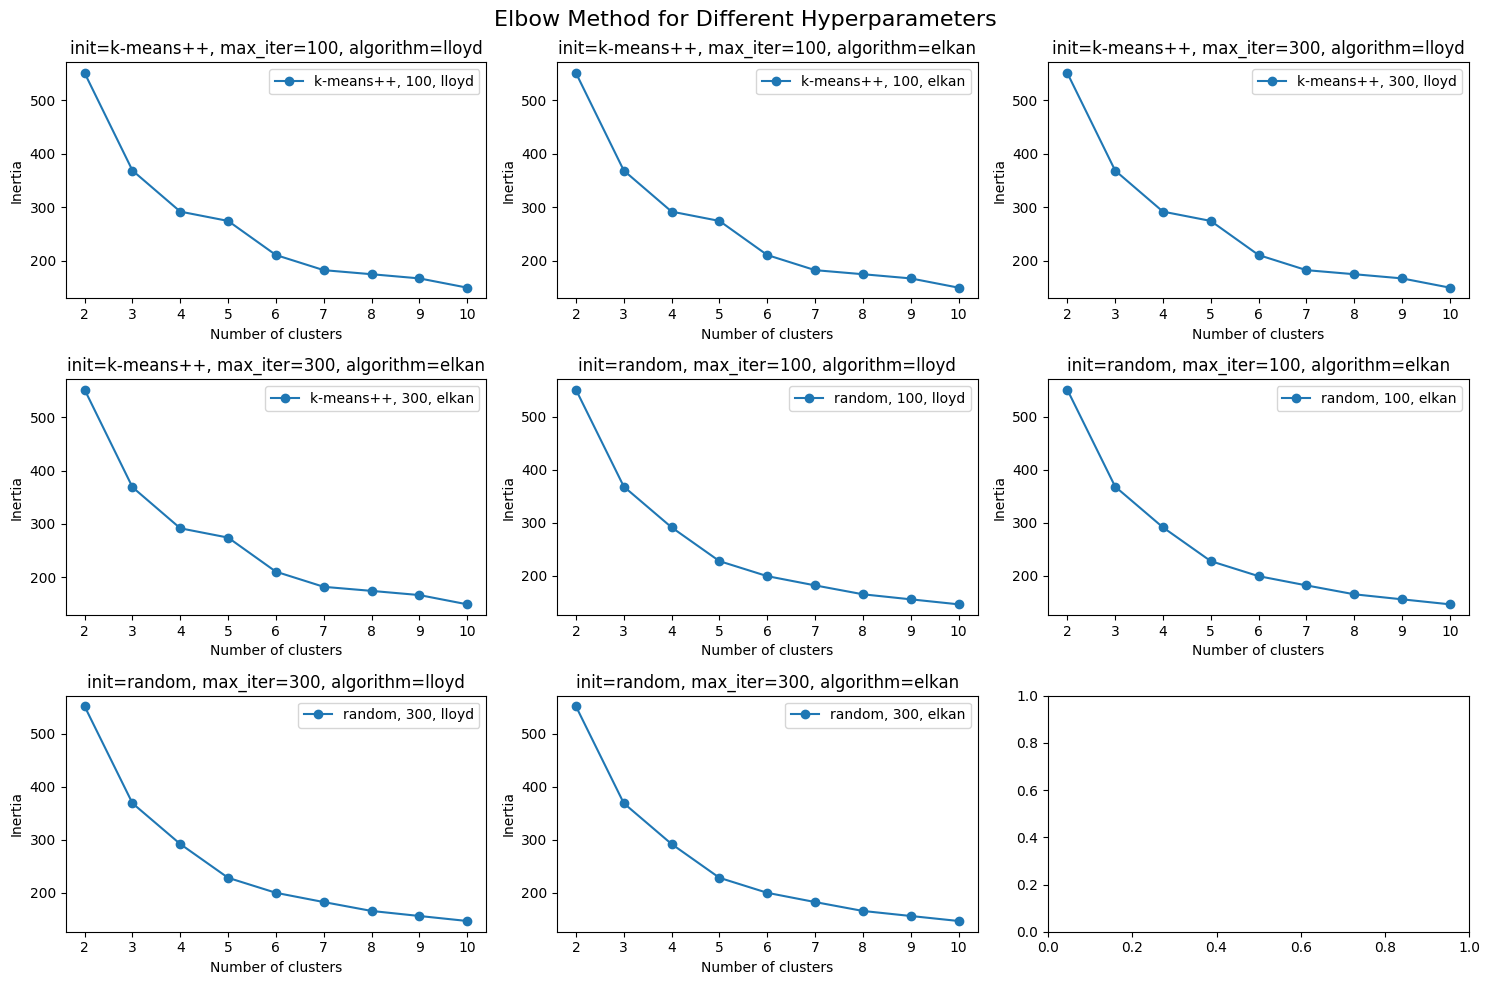

In [6]:
# Графики
n_rows = 3  # Количество строк
n_cols = 3  # Количество столбцов
graphs_per_figure = n_rows * n_cols  # Количество графиков на одной фигуре

# Счетчик для отслеживания текущего графика
graph_counter = 0

# Перебор комбинаций гиперпараметров
for init in init_methods:
    for max_iter in max_iter_range:
        for algorithm in algorithms:
            subset = results_df[
                (results_df['init'] == init) &
                (results_df['max_iter'] == max_iter) &
                (results_df['algorithm'] == algorithm)
            ]
            
            if graph_counter % graphs_per_figure == 0:
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Сетка графиков
                fig.suptitle(f'Elbow Method for Different Hyperparameters', fontsize=16)
                axes = axes.flatten()  # Преобразование осей в одномерный массив
            
            # Построение графика
            ax = axes[graph_counter % graphs_per_figure]
            ax.plot(subset['n_clusters'], subset['inertia'], marker='o', label=f'{init}, {max_iter}, {algorithm}')
            ax.set_xlabel('Number of clusters')
            ax.set_ylabel('Inertia')
            ax.set_title(f'init={init}, max_iter={max_iter}, algorithm={algorithm}')
            ax.legend()
            
            graph_counter += 1

            if graph_counter % graphs_per_figure == 0 or graph_counter == len(init_methods) * len(max_iter_range) * len(algorithms):
                plt.tight_layout()
                plt.show()

Выводы:
- Для каждого значения n_clusters инерция практически не меняется при изменении max_iter и algorithm, параметры не оказывают значительного влияния на результат.
- Метод инициализации k-means++ и random дают схожие результаты, но в некоторых случаях random показывает чуть меньшую инерцию.
- Локоть четко не просматривается.
- Лучшие параметры:

    - init: k-means++ (более стабильный метод инициализации).

    - max_iter: 100 (так как увеличение до 300 не влияет на результат).

    - algorithm: lloyd (стандартный алгоритм, результаты идентичны elkan)
- Для принятия решения по количеству классов применю метод силуэтов




- метод силуэта

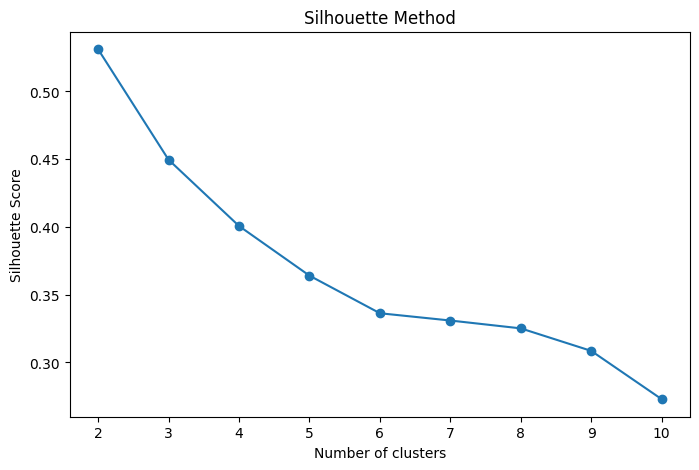

In [7]:
inertia = []
K_range = range(1, 11)
silhouette_scores = []

for k in K_range:
    if k == 1:
        continue 
    kmeans = KMeans(
    k,                      # Количество кластеров
    init='k-means++',       # инициализация центроидов
    max_iter=100,           # Максимальное количество итераций
    algorithm='lloyd',      # Стандартный алгоритм
    random_state=42         # Фиксация случайных значений для воспроизводимости
    )
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# График
plt.figure(figsize=(8, 5))
plt.plot(K_range[1:], silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

- Наивысший silhouette score наблюдается при n_clusters=2 (0.6107).

- С увеличением количества кластеров silhouette score постепенно уменьшается.

Вывод:

- При n_clusters=2 кластеры наиболее четко разделены.

- При увеличении количества кластеров качество кластеризации ухудшается (кластеры становятся менее различимыми)
- Оптимальное количество кластеров = 2

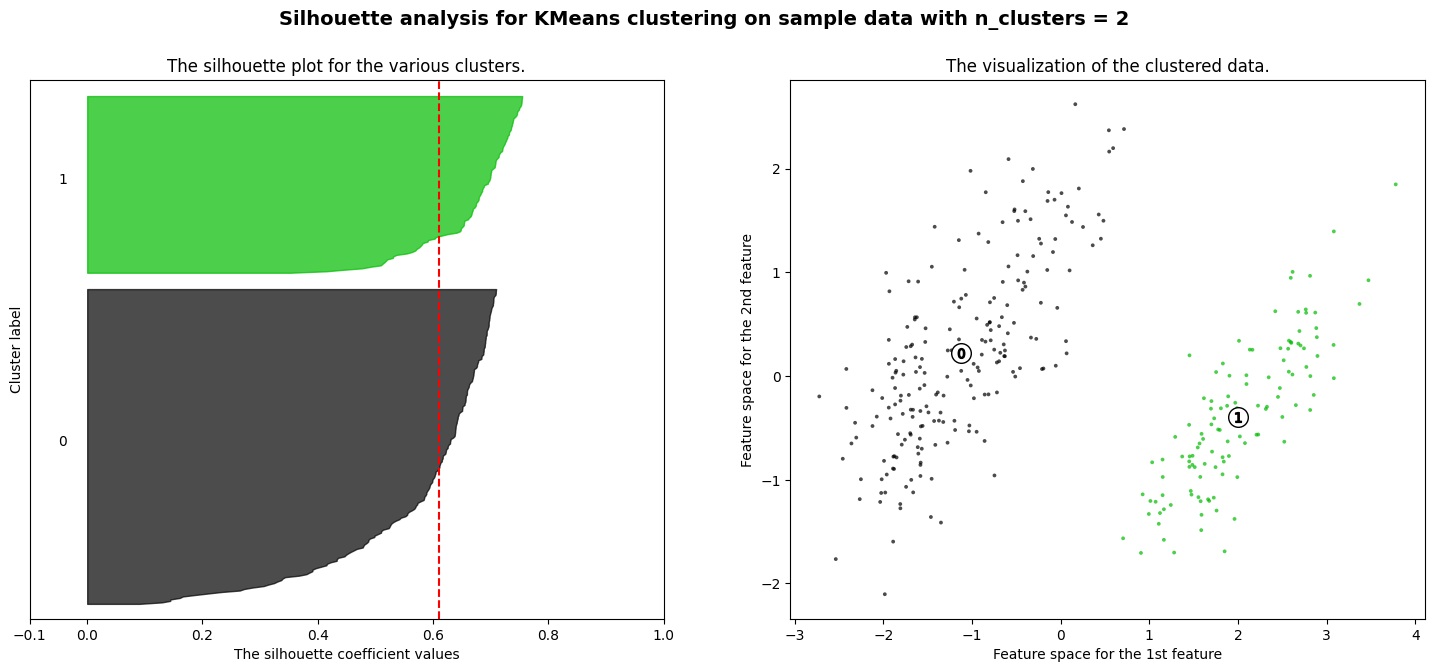

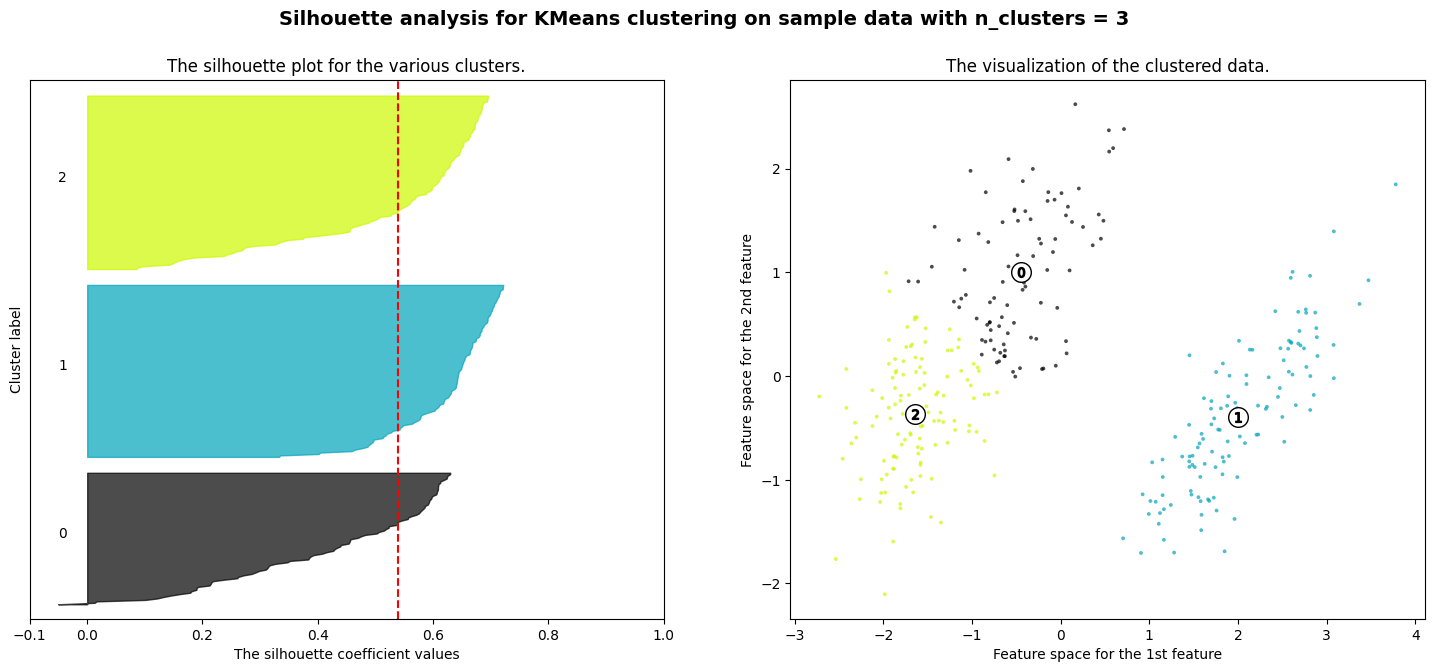

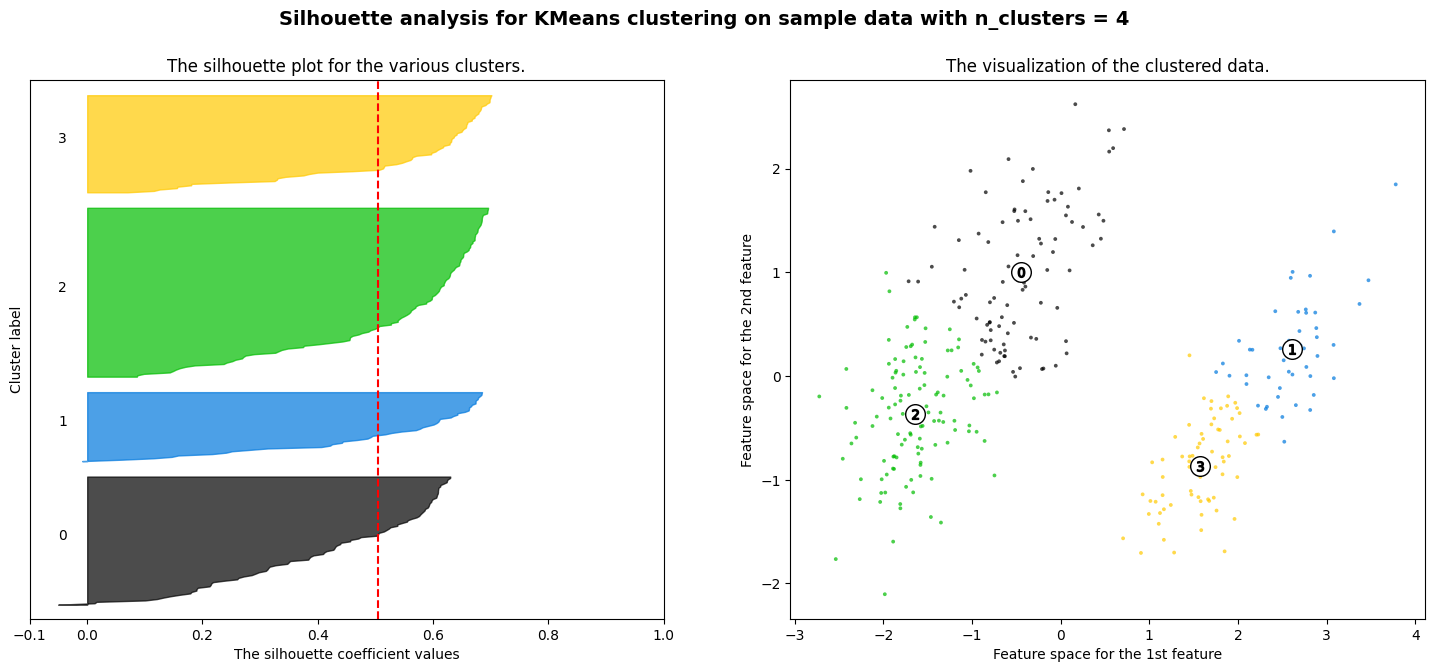

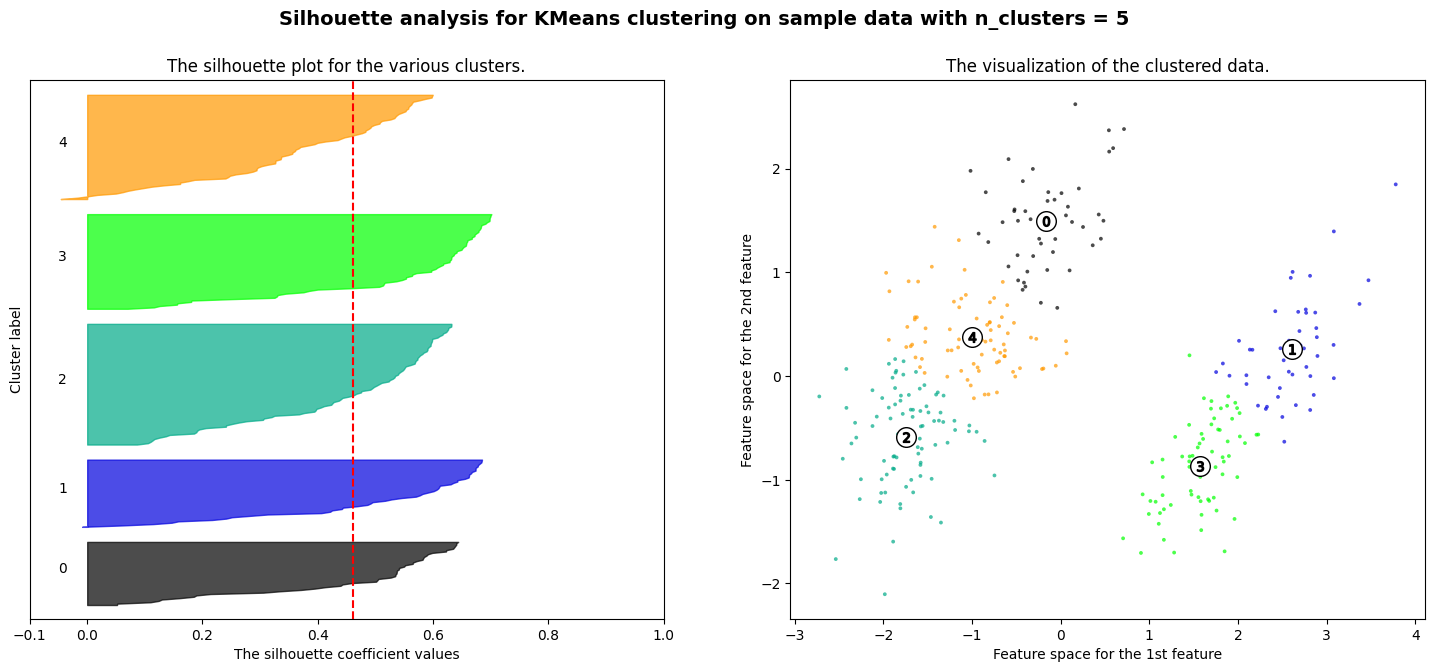

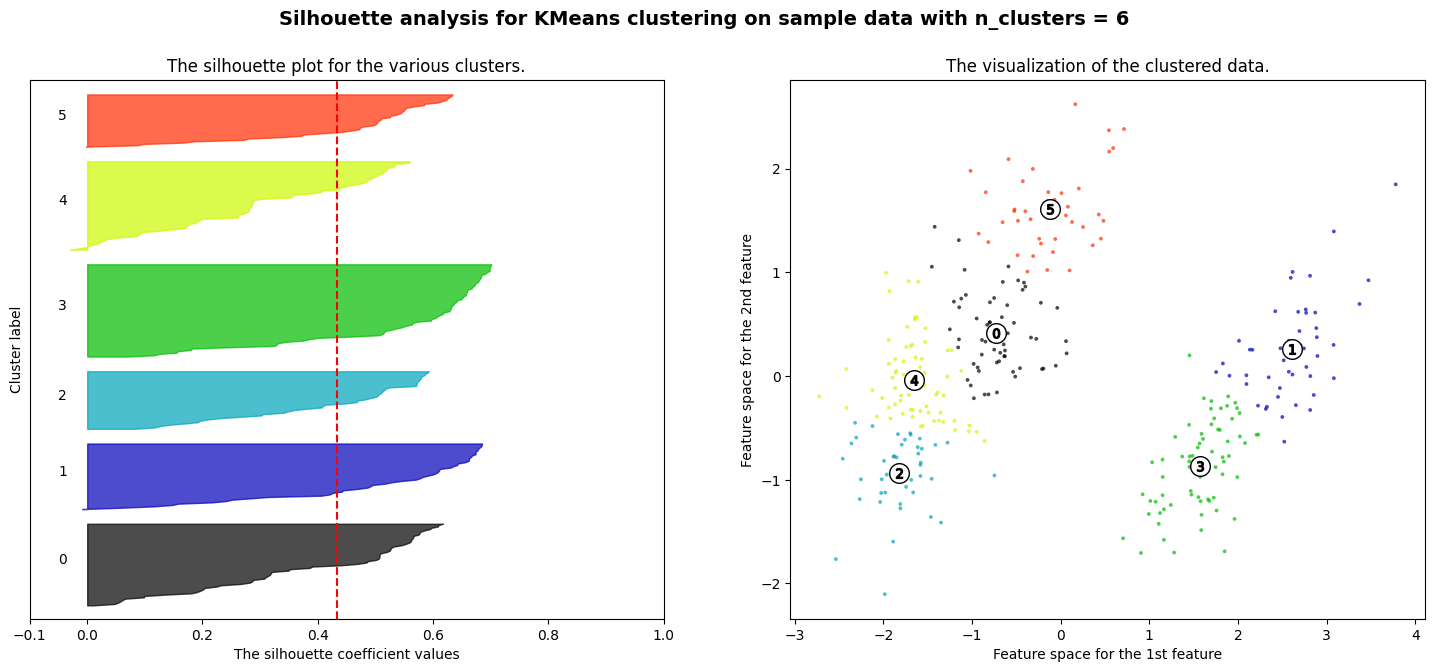

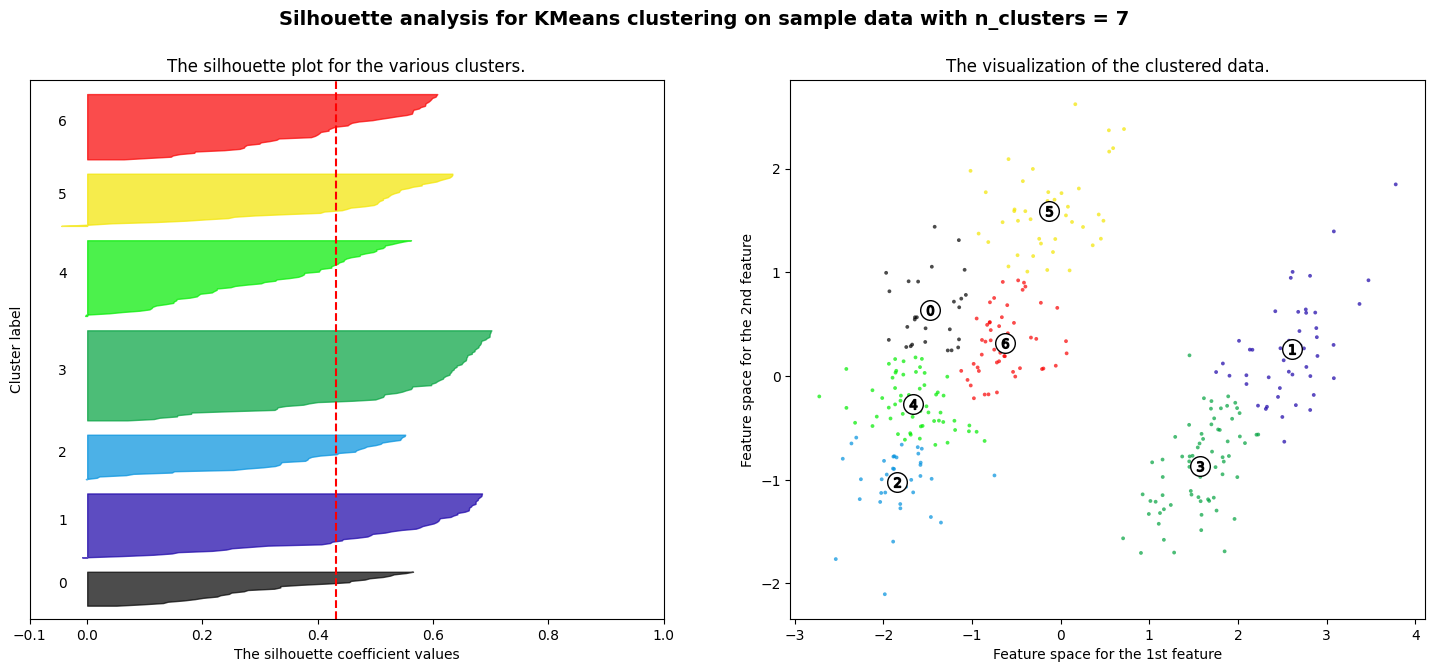

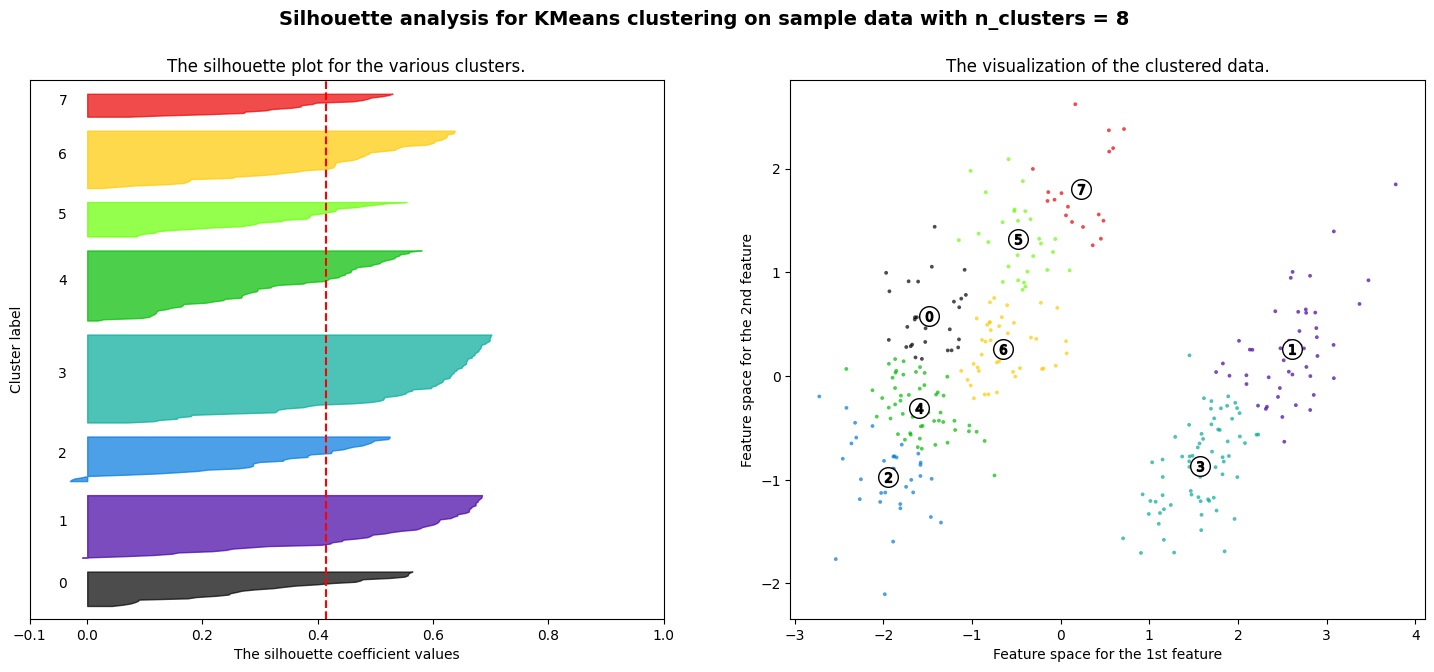

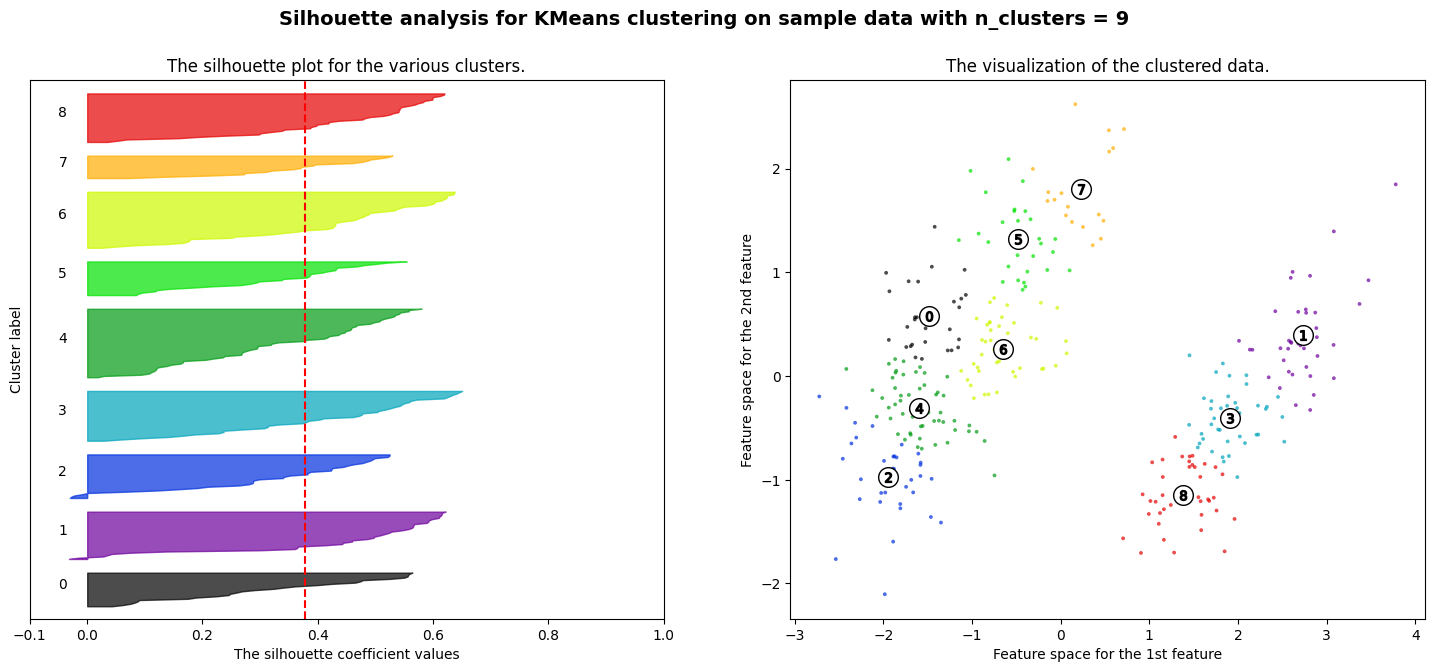

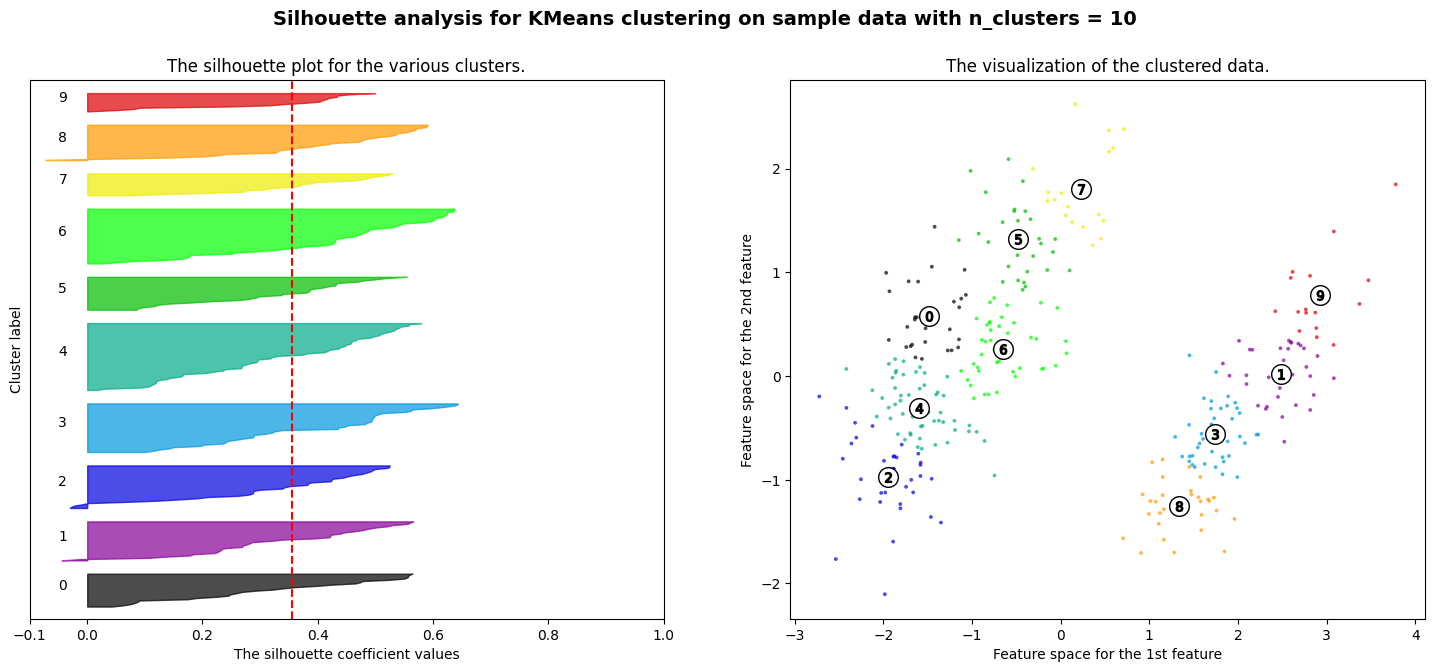

In [ ]:
'''
-----------------------------------------------------
Данную ячейку передрал с лекции
Для домашнего задания, думаю, она не обязательна,
для истории важна :-)
-----------------------------------------------------
'''
reduced_data = PCA(n_components=2).fit_transform(X_scaled) # уменьшение размерности PCA
# Cписок для записи коэффициентов силуэта для каждого образца
sample_silhouette_values = []

min_range = 2
max_range = 11 

for i in range(min_range, max_range):
    # Подзаголовок с 1 строкой и 2 столбцами
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Первый подсюжет — это график силуэта
    # Коэффициент силуэта может варьироваться от -1 до 1
    ax1.set_xlim([-0.1, 1])
    # (n_clusters+1)*10 предназначен для вставки пустого пространства между силуэтами
    # графики отдельных кластеров, чтобы четко их разграничить.
    ax1.set_ylim([0, len(reduced_data) + (i + 1) * 10])

    # Инициализируем кластеризатор значением n_clusters и генератором случайных чисел
    # начальное число из 42 для воспроизводимости.
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(reduced_data)

    # Silhouette_score дает среднее значение для всех образцов.
    # Это дает представление о плотности и разделении образовавшихся
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    # print(
    #     "For n_clusters =", i, "The average silhouette_score is :", silhouette_avg,
    # ) # рассчет коэффициента, можно без визуализации

    # Вычисляем оценки силуэта для каждого образца
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for j in range(i):
        # Объединить оценки силуэтов для образцов, принадлежащих
        # кластер j и сортировка
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / i)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Пометка номерами  кластеров посередине.
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Вычисляем новый y_lower для следующего графика
        y_lower = y_upper + 10  # 10 для 0 образцов

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Вертикальная линия для средней оценки силуэта всех значений.
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Очистите метки/галочки Yaxis
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2-й график, показывающий фактически сформированные кластеры
    colors = cm.nipy_spectral(cluster_labels.astype(float) / i)
    ax2.scatter(
        reduced_data[:, 0], reduced_data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Маркировка кластеров
    centers = clusterer.cluster_centers_
    # Белые круги в центрах кластеров
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for k, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % k, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % i,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### Кластеризация на лучших параметрах

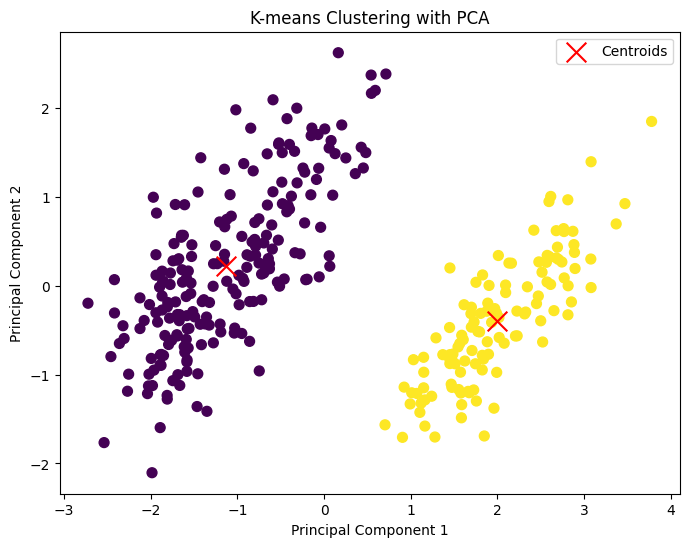

In [9]:
# PCA для снижения размерности
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Кластеризация 
kmeans = KMeans(
    n_clusters=2,           # Количество кластеров
    init='k-means++',       # Инициализация центроидов
    max_iter=100,           # Максимальное количество итераций
    algorithm='lloyd',      # Стандартный алгоритм
    random_state=42         # Фиксация случайных значений для воспроизводимости
)

# Обучение модели
kmeans.fit(X_scaled)

# Преобразование центроидов в пространство PCA
centroids_pca = pca.transform(kmeans.cluster_centers_)

# График
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('K-means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
 

In [10]:
# Сохранение модели
joblib.dump(kmeans, 'kmeans_model.pkl')
print('Модель сохранена в файл: kmeans_model.pkl')

Модель сохранена в файл: kmeans_model.pkl
